In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import dill

### 1. Data Processing:

In [2]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()

In [3]:
X = pd.DataFrame(diabetes['data'], columns = diabetes['feature_names'])

In [4]:
y = pd.DataFrame(diabetes['target'], columns = ['y'])

#### Features:

In [5]:
data = X
data = data * np.shape(data)[0]
data['y'] = np.log(y)
data['sex'][data['sex']>0] = 1
data['sex'][data['sex']<0] = 0
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,16.829551,1.0,27.269723,9.667581,-19.546786,-15.390777,-19.183174,-1.145780,8.799522,-7.799587,5.017280
1,-0.831851,0.0,-22.751535,-11.636903,-3.734336,-8.470196,32.889911,-17.456075,-30.201747,-40.754190,4.317488
2,37.702117,1.0,19.647436,-2.506410,-20.154957,-15.113954,-14.301322,-1.145780,1.265787,-11.461210,4.948760
3,-39.365819,0.0,-5.124996,-16.202149,5.388231,11.045842,-15.928606,15.164516,10.029874,-4.137965,5.327876
4,2.379313,0.0,-16.082034,9.667581,1.739204,6.893494,3.598801,-1.145780,-14.140219,-20.615266,4.905275


#### Labels:

In [6]:
y.T

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
y,151.0,75.0,141.0,206.0,135.0,97.0,138.0,63.0,110.0,310.0,...,173.0,72.0,49.0,64.0,48.0,178.0,104.0,132.0,220.0,57.0


In [7]:
train, test = train_test_split(data, test_size=0.2)

In [8]:
age_tensor = theano.shared(train.age.values.astype('float64'))
sex_tensor = theano.shared(train.sex.values.astype('float64'))
bmi_tensor = theano.shared(train.bmi.values.astype('float64'))
bp_tensor = theano.shared(train.bp.values.astype('float64'))
y_tensor = theano.shared(train.y.values.astype('float64'))

### 2. Fit Model using HMC

In [9]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=1)
    beta_age = pm.Normal('beta_age', mu=0, sd=1, shape=1)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=1, shape=1)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=1, shape=1)
    beta_bp = pm.Normal('beta_bp', mu=0, sd=1, shape=1)
    sigma = pm.Gamma('sigma', alpha=0.5, beta=0.5, shape=1)
    mu_likelihood = alpha + beta_age * age_tensor + beta_sex * sex_tensor + beta_bmi * bmi_tensor + beta_bp * bp_tensor
    y_likelihood = pm.Normal('y', mu=mu_likelihood, sd=sigma, observed=y_tensor)

In [10]:
np.random.seed(47294)
with model:
    step = pm.NUTS()
    hmc_trace = pm.sample(draws=50000, tune=1000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_bp, beta_bmi, beta_sex, beta_age, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████| 102000/102000 [02:27<00:00, 693.08draws/s]


In [11]:
#pm.traceplot(hmc_trace)
pm.summary(hmc_trace)

C:\Users\chris\Anaconda3\envs\ml\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,4.898501,0.032605,0.000105,4.834731,4.962859,94304.822810,1.000057
beta_age__0,0.000834,0.001187,0.000004,-0.001499,0.003162,110660.017812,0.999995
beta_sex__0,-0.034035,0.049601,0.000169,-0.131370,0.062995,92221.549620,1.000046
beta_bmi__0,0.011637,0.001257,0.000004,0.009117,0.014040,108456.136277,0.999995
beta_bp__0,0.006568,0.001342,0.000004,0.003972,0.009218,102641.246642,0.999995
sigma__0,0.447019,0.017045,0.000048,0.413864,0.480606,105882.233952,0.999994


### 3. Fit model using Variational Inference

#### Map tensors for custom gradients:

In [12]:
map_tensor_batch = {age_tensor: pm.Minibatch(train.age.values, 100),
                    sex_tensor: pm.Minibatch(train.sex.values, 100),
                    bmi_tensor: pm.Minibatch(train.bmi.values, 100),
                    bp_tensor: pm.Minibatch(train.bp.values, 100),
                    y_tensor: pm.Minibatch(train.y.values, 100)}

C:\Users\chris\Anaconda3\envs\ml\lib\site-packages\pymc3\data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\Users\chris\Anaconda3\envs\ml\lib\site-packages\pymc3\data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [13]:
np.random.seed(34564)
with model:
    #advi_fit = pm.fit(method='asvgd', n=50000, more_replacements=map_tensor_batch)
    advi_fit = pm.fit(method='advi', n=40000, more_replacements=map_tensor_batch)

Average Loss = 100.56: 100%|███████████████████████████████████████████████████| 40000/40000 [00:38<00:00, 1036.87it/s]
Finished [100%]: Average Loss = 100.52


In [14]:
#advi_elbo = pd.DataFrame(
#    {'log-ELBO': -np.log(advi_fit.hist),
#     'n': np.arange(advi_fit.hist.shape[0])})

#_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [44]:
np.random.seed(324554)

advi_trace = advi_fit.sample(10000)
#pm.traceplot(advi_trace)
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,4.884249,0.052780,0.000548,4.779077,4.986309
beta_age__0,0.000322,0.002495,0.000026,-0.004652,0.005053
beta_sex__0,-0.015906,0.075877,0.000863,-0.166859,0.129782
beta_bmi__0,0.012281,0.002524,0.000022,0.007442,0.017272
beta_bp__0,0.005534,0.002552,0.000025,0.000376,0.010394
sigma__0,0.463553,0.035723,0.000411,0.395286,0.534026


### 4. Make predictions on test data:

In [16]:
age_tensor.set_value(test.age.values.astype('float64'))
sex_tensor.set_value(test.sex.values.astype('float64'))
bmi_tensor.set_value(test.bmi.values.astype('float64'))
bp_tensor.set_value(test.bp.values.astype('float64'))
y_tensor.set_value(test.y.values.astype('float64'))

C:\Users\chris\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.33it/s]
C:\Users\chris\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.98it/s]


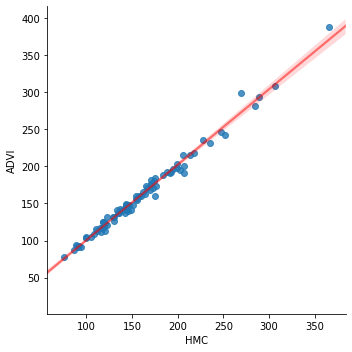

In [17]:
hmc_posterior_pred = pm.sample_ppc(hmc_trace, 1000, model)
hmc_predictions = np.mean(np.exp(hmc_posterior_pred['y']), axis=0)

advi_posterior_pred = pm.sample_ppc(advi_trace, 1000, model)
advi_predictions = np.mean(np.exp(advi_posterior_pred['y']), axis=0)

prediction_data = pd.DataFrame(
    {'HMC': hmc_predictions, 
     'ADVI': advi_predictions, 
     'actual': np.exp(test.y),
     'error_HMC': hmc_predictions - np.exp(test.y), 
     'error_ADVI': advi_predictions - np.exp(test.y)})

g = sns.lmplot(y='ADVI', x='HMC', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})
g.set(ylim=1)

In [18]:
np.shape(hmc_predictions)

(89,)

In [19]:
results = pd.DataFrame(np.exp(test.y))
results['pred_hmc'] = hmc_predictions
results['pred_advi'] = advi_predictions
results

,y,pred_hmc,pred_advi
233,90.0,153.898635,159.969799
67,97.0,130.166385,132.080338
2,141.0,183.753833,187.917137
119,200.0,116.059194,111.322911
382,132.0,194.843206,196.874672
...,...,...,...
218,214.0,94.009551,91.471839
117,281.0,175.254769,160.171168
341,263.0,227.224506,235.595933
91,164.0,166.628286,171.522400


In [20]:
np.sqrt(np.sum(np.square(np.array(results['y'])- np.array(results['pred_hmc']))))

573.4391311396222

In [21]:
np.sqrt(np.sum(np.square(np.array(results['y'])- np.array(results['pred_advi']))))

586.7321890627509

#### Comparison to mean prediction on test data:

In [22]:
np.sqrt(np.sum(np.square(np.mean(test.y.values.astype('float64'))- np.array(results['pred_hmc']))))

1530.3804560142937

### 5. Pareto Smoothed Importance Sampling

In [270]:
y_tensor.set_value(train.y.values.astype('float64'))

In [260]:
def PSIS(sample, drop=['sigma_log__']):
    dists = {}
    imp_weights = []
    variables = list(sample.varnames)
    for d in drop:
        variables.remove(d)
    n = len(sample[variables[0]])
    for var in variables:
        dists[var] = stats.gaussian_kde(sample[var][~np.isnan(sample[var])])
    for i in range(n):
        q = 1
        for var in variables:
            q *= dists[var].evaluate(sample[i][var][0])
        theta = list(pd.DataFrame(sample[i]).values[0])
        for d in drop:
            theta.pop(sample.varnames.index(d))
        p = np.sum(np.log(stats.norm.pdf(theta[:5]))) + np.log(stats.gamma.pdf(theta[-1], 0.5, scale=2))
        exp_value = theta[0] + theta[1]*age_tensor.get_value() + theta[2]*sex_tensor.get_value() + \
                        theta[3]*bmi_tensor.get_value() + theta[4]*bp_tensor.get_value()
        p += np.sum(np.log(stats.norm.pdf(y_tensor.get_value(), loc=exp_value, scale=theta[5])))
        imp_weights.append((np.exp(p-np.log(q)))[0])
    imp_weights = np.array(imp_weights)
    M = int(round(min(n/5, 3*np.sqrt(n))))
    gen_par_fit = stats.genpareto.fit(np.sort(imp_weights)[-M:]/np.sum(np.sort(imp_weights)[-M:])*(1e3))
    trunc_weights = np.copy(imp_weights)
    if gen_par_fit[0]<1:
        mean_fit = gen_par_fit[1] + gen_par_fit[2]/(1-gen_par_fit[0])
        trunc_weights[imp_weights >= np.sort(imp_weights)[-M]] = mean_fit*np.sum(np.sort(imp_weights)[-M:])/(1e3)
    else:
        mean_fit = np.infty
        trunc_weights[imp_weights >= np.sort(imp_weights)[-M]] = np.sort(imp_weights)[-1]
    k = gen_par_fit[0]
    return [k, imp_weights, trunc_weights,  gen_par_fit]

#### Importance weights are small, as the posterior density is unnormalised.

In [282]:
psis_model = PSIS(advi_trace)

In [294]:
stats.genpareto.fit(np.sort(psis_model[1])[-M:]/np.sum(np.sort(psis_model[1])[-M:])*(1e3))

(0.1512228143516779, 1.4158378385754335, 1.6351843919354239)

### Value of k:

In [305]:
psis_model[0]

0.1512228143516779

### 6. VI Diagnostics: VSBC:

In [119]:
age_tensor.set_value(train.age.values.astype('float64'))
sex_tensor.set_value(train.sex.values.astype('float64'))
bmi_tensor.set_value(train.bmi.values.astype('float64'))
bp_tensor.set_value(train.bp.values.astype('float64'))

Cell below take ages to run (does VI n times) - produces results

In [ ]:
np.random.seed(9472952)
errs = []
n = 300
l=10000
sim = {}
variables = ['alpha','beta_age','beta_sex','beta_bmi','beta_bp','sigma']
p_values = {}
p_values_is = {}
p_values_psis = {}
k_s = []

for var in variables:
    sim[var] = []
    p_values[var] = []
    p_values_is[var] = []
    p_values_psis[var] = []

for i in range(n):
    if ((i+1) % 5) == 0:
        print("Iteration %s of %s" % (i+1, n))
    for var in variables:
        sim[var].append(stats.norm.rvs(size=1)[0])
    sim['sigma'][-1] = stats.gamma.rvs(0.5, scale=2, size=1)[0]
    exp_value = sim['alpha'][-1] + sim['beta_age'][-1]*age_tensor.get_value() + sim['beta_sex'][-1]*sex_tensor.get_value() + \
                    sim['beta_bmi'][-1]*bmi_tensor.get_value() + sim['beta_bp'][-1]*bp_tensor.get_value()
    sim['y'] = stats.norm.rvs(loc=exp_value, scale=sim['sigma'][-1], size=len(exp_value)) 
    y_tensor.set_value(sim['y'])
    with model:
        advi_fit = pm.fit(method='advi', progressbar = False, n=50000)
    advi_sample = advi_fit.sample(l)
    psis_output = PSIS(advi_sample)
    k_s.append(psis_output[0])
    try:
        is_indices = np.random.choice(np.arange(l), size=l, p=psis_output[1]/np.sum(psis_output[1]))
    except:
        errs.append(1)
        for var in variables:
            p_values[var].append(np.sum(advi_sample[var]<sim[var][-1])/len(advi_sample[var]))
        continue
    errs.append(0)
    psis_indices = np.random.choice(np.arange(l), size=l, p=psis_output[2]/np.sum(psis_output[2]))
    for var in variables:
        p_values[var].append(np.sum(advi_sample[var]<sim[var][-1])/len(advi_sample[var]))
        p_values_is[var].append(np.sum(advi_sample[var][is_indices]<sim[var][-1])/l)
        p_values_psis[var].append(np.sum(advi_sample[var][psis_indices]<sim[var][-1])/l)

### Run the cell below to load the final results:

In [367]:
with open(filename, 'rb') as f:
    [p_values, p_values_is, p_values_psis, errs, k_s] = dill.load(f)

### Standard VI p-values:

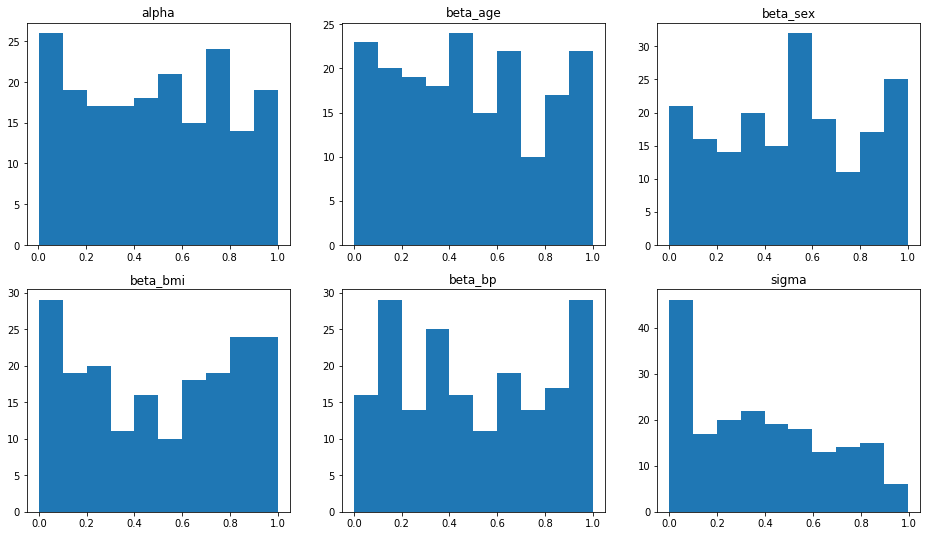

In [346]:
fig, axes = plt.subplots(2,3)
axes = axes.reshape(6,)
for i in range(6):
    axes[i].hist(p_values[variables[i]])
    axes[i].set_title(variables[i])
#for key, value in p_values:
fig.set_size_inches(16,9)
plt.show()

### VI with IS p-values

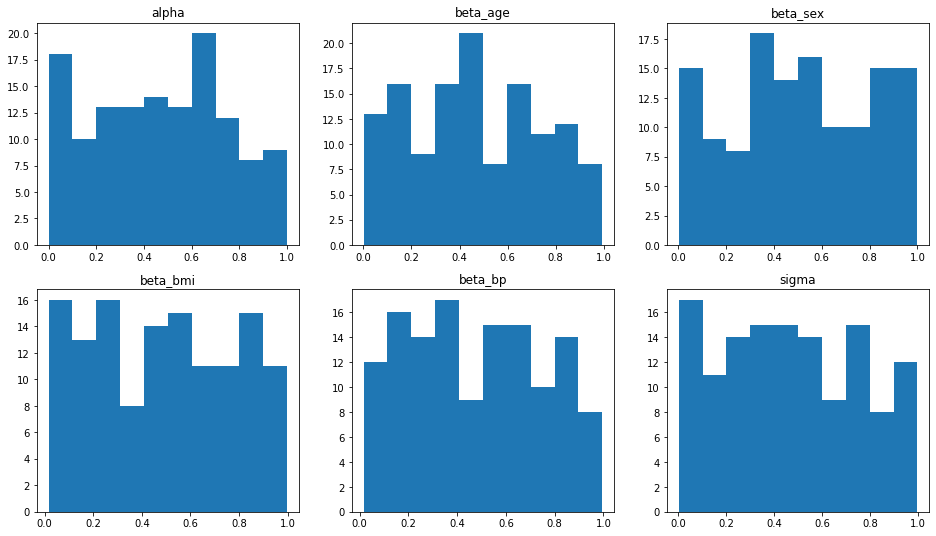

In [347]:
fig, axes = plt.subplots(2,3)
axes = axes.reshape(6,)
for i in range(6):
    axes[i].hist(p_values_is[variables[i]])
    axes[i].set_title(variables[i])
#for key, value in p_values:
fig.set_size_inches(16,9)
plt.show()

### VI with PSIS p-values

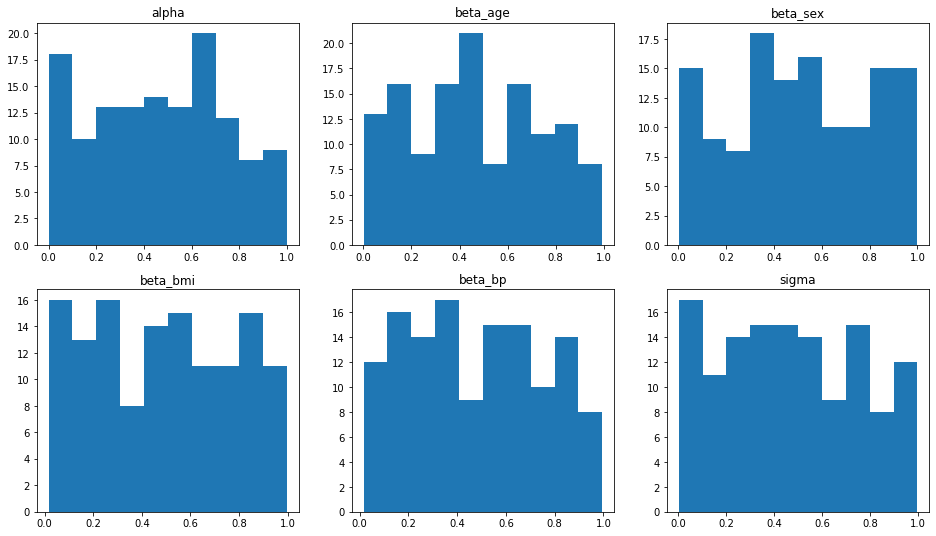

In [348]:
fig, axes = plt.subplots(2,3)
axes = axes.reshape(6,)
for i in range(6):
    axes[i].hist(p_values_is[variables[i]])
    axes[i].set_title(variables[i])
#for key, value in p_values:
fig.set_size_inches(16,9)
plt.show()

p-values for IS and PSIS appear to be very similar....

In [352]:
p_values_psis['alpha'][:10]

[0.536, 0.3279, 0.703, 0.2867, 0.9986, 0.0052, 0.5268, 0.9148, 0.5595, 0.7069]

In [353]:
p_values_is['alpha'][:10]

[0.5477, 0.3334, 0.7026, 0.3061, 0.9984, 0.015, 0.5286, 0.9313, 0.5453, 0.6958]

Just over half of the generated k values are below 0.7 (indicating reasonable VI sample)

In [375]:
np.sum(np.array(k_s)<=0.7)/len(np.array(k_s))

0.5340314136125655

Results show visual improvement in sampling quality of sigma, can add to the report.

In [357]:
# filename = 'p_value_results.pkl'
# with open(filename, 'wb') as f:
#     dill.dump([p_values, p_values_is, p_values_psis, errs, k_s], f)

### Scrap Code

In [173]:
sample = advi_sample
dists = {}
imp_weights = []
variables = ['alpha', 'beta_age', 'beta_sex', 'beta_bmi', 'beta_bp', 'sigma']
n = len(sample[variables[0]])
for var in variables:
    dists[var] = stats.gaussian_kde(sample[var][~np.isnan(sample[var])])
for i in range(n):
    q = 1
    for var in variables:
        q *= dists[var].evaluate(sample[i][var][0])
    theta = list(pd.DataFrame(sample[i]).values[0])
    theta.pop(5)
    p = np.sum(np.log(stats.norm.pdf(theta[:5]))) + np.log(stats.gamma.pdf(theta[-1], 0.5, scale=2))
    exp_value = theta[0] + theta[1]*age_tensor.get_value() + theta[2]*sex_tensor.get_value() + \
                    theta[3]*bmi_tensor.get_value() + theta[4]*bp_tensor.get_value()
    p += np.sum(np.log(stats.norm.pdf(y_tensor.get_value(), loc=exp_value, scale=theta[5])))
    imp_weights.append(np.exp(p-np.log(q))[0])
imp_weights = np.array(imp_weights)
M = int(round(min(n/5, 3*np.sqrt(n))))
gen_par_fit = stats.genpareto.fit(np.sort(imp_weights)[-M:])
if gen_par_fit[0]<1:
    mean_fit = gen_par_fit[1] + gen_par_fit[2]/(1-gen_par_fit[0])
else:
    mean_fit = np.infty
trunc_weights = np.copy(imp_weights)
trunc_weights[imp_weights >= np.sort(imp_weights)[-M]] = mean_fit
k = gen_par_fit[0]